## Gecco '22

Analysis of the results achieved for the conference Gecco '22.

In [1]:
DPI = 400  # affects the plot saved on disk

In [2]:
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns

The cluster code produced three parquet files, "seed{i}v2.parquet" for i in {0, 1, 2}. These are at "/data/experiments".

In [3]:
project_root = pathlib.Path().resolve().parent.parent.parent
experiments_path = project_root / "data" / "experiments"

In [4]:
data = (
    pd.concat(
        [
            pd.read_parquet(experiments_path / "seed0v2.parquet").assign(Run="Run 1"),
            pd.read_parquet(experiments_path / "seed1v2.parquet").assign(Run="Run 2"),
            pd.read_parquet(experiments_path / "seed2v2.parquet").assign(Run="Run 3"),
        ],
        ignore_index=True,
    )
    .sort_values(by="Run", ascending=True)
    .rename(
        columns={
            "gen": "Generation",
            "fit": "Fitness",
            "layers": "Layer count",
            "skips": "Merge layer count",
            "params": "Total parameters",
        }
    )
)

### Average fitness per generation

Not super important since there are differing amount of generations for each experiment, but it's important to notice a growing trending in all three cases.

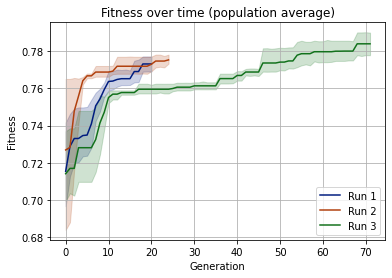

In [5]:
ax = sns.lineplot(data=data, x="Generation", y="Fitness", hue="Run", palette="dark")
ax.grid()
ax.set_title("Fitness over time (population average)")
ax.legend(loc="lower right")
None

### All variables per generation

This is the main study. We are interested in knowing how the fitness, layer and merge layer count, and total parameters change as the population evolves, separately per experiment.

While we want the fitness to have a good growing trending, the effect for other variables are unknown. It's interesting that the same strategies for changing these variables are not the same for the three experiments.

In [6]:
# the default way seaborn/pyplot represent order of magnitude can be confusing;
# this is just to keep it easier to read
_m = data.copy()
_m["Total parameters"] = _m["Total parameters"] / (10 ** 8)
_m = _m.rename(columns={"Total parameters": "Total parameters (10⁸)"})

# treating all variables as the same "kind" so we can map over them
melted_data = pd.melt(
    _m,
    id_vars=["Generation", "id", "Run"],
    value_vars=[
        "Fitness",
        "Layer count",
        "Merge layer count",
        "Total parameters (10⁸)",
    ],
)

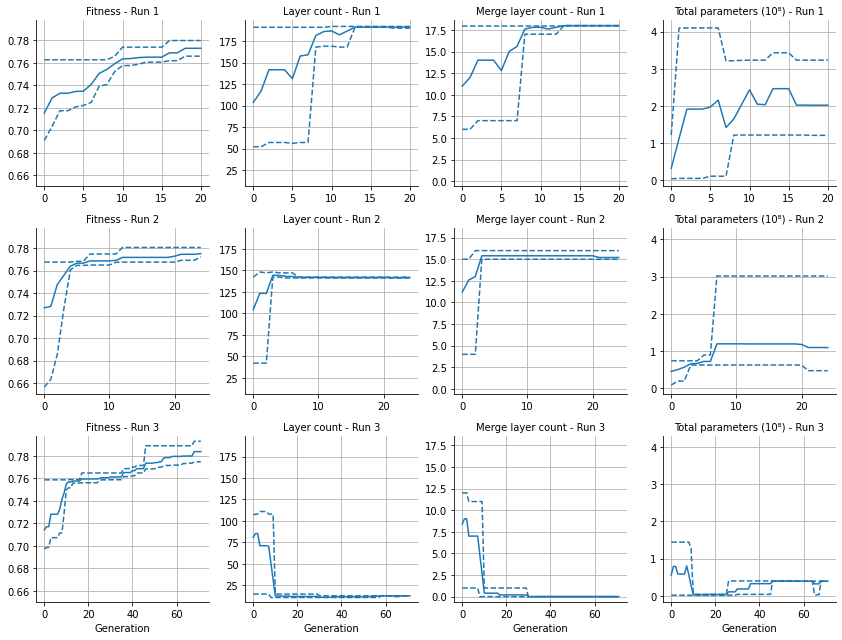

In [7]:
g = sns.FacetGrid(melted_data, col="variable", row="Run", sharex=False, sharey=False)
g.map(sns.lineplot, "Generation", "value", estimator="max", ci=None, linestyle="--")
g.map(sns.lineplot, "Generation", "value", estimator="min", ci=None, linestyle="--")
g.map(sns.lineplot, "Generation", "value", estimator="mean", ci=None)
g.set_titles(template="{col_name} - {row_name}")
g.set_ylabels("")

# align y-axes vertically (i.e. each plot in the same column has the same y-axis scale)
for col_num in range(4):
    col = g.axes[:, col_num]
    lims = np.array([ax.get_ylim() for ax in col])
    minima = lims[:, 0].min()
    maxima = lims[:, 1].max()

    for plot in col:
        plot.set_ylim((minima, maxima))
        plot.grid()  # add a grid to every plot as well

g.figure.savefig("grid.png", transparent=False, facecolor="white", dpi=DPI)
None

### Relation between fitness and other variables

Does making the network deeper increase the accuracy? What about more skip connections or just adding parameters?

The data suggests the relation, if any, is minimal. There's a certain point where the total parameters is high enough to not produce poor networks, however very few networks reached more than $2 \cdot 10^8$ parameters. Thus having changes in the topology itself may be more important than adjusting these variables within the same topology.

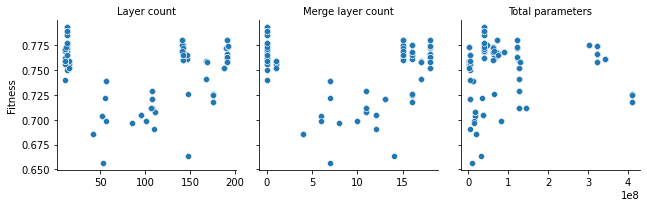

In [8]:
molten_by_fitness = pd.melt(
    data,
    id_vars=["Fitness"],
    value_vars=["Layer count", "Merge layer count", "Total parameters"],
)

g = sns.FacetGrid(molten_by_fitness, col="variable", sharey=True, sharex=False)
g.map(sns.scatterplot, "value", "Fitness")
g.set_titles(template="{col_name}")
g.set_xlabels("")
None

In [9]:
variables = data[["Fitness", "Layer count", "Merge layer count", "Total parameters"]]
variables.corr(method="spearman")

,Fitness,Layer count,Merge layer count,Total parameters
Fitness,1.000000,-0.030969,-0.149411,0.194445
Layer count,-0.030969,1.000000,0.948715,0.656422
Merge layer count,-0.149411,0.948715,1.000000,0.711113
Total parameters,0.194445,0.656422,0.711113,1.000000


### Other quick questions

Is the generation 0-indexed or 1-indexed?

In [10]:
data["Generation"].min()

0

How many generations were there per experiment?

In [11]:
data.groupby("Run")["Generation"].max()

Run
Run 1    20
Run 2    24
Run 3    71
Name: Generation, dtype: int64

What was the best network at the 21th generation (the highest achieved in all experiments)?

In [12]:
def agg_per(data, group, variable, agg):
    """Get the rows with agg (max/min) value for variable within each group."""
    return data[data.groupby(group)[variable].transform(agg) == data[variable]]

In [13]:
gen20 = data.query("Generation == 20")
agg_per(gen20, "Run", "Fitness", max)

,Generation,id,Fitness,Layer count,Merge layer count,Total parameters,Run
85,20,19,0.7799,191,18,121813898,Run 1
131,20,14,0.7806,141,15,72193546,Run 2
438,20,15,0.7648,13,0,3884810,Run 3


What was the best network generated by each experiment, and how early in the evolutionary process was it produced?

In [14]:
maxima = agg_per(data, "Run", "Fitness", max)
first_occurrence = agg_per(maxima, "Run", "Generation", min)

first_occurrence

,Generation,id,Fitness,Layer count,Merge layer count,Total parameters,Run
55,16,19,0.7799,191,18,121813898,Run 1
158,12,14,0.7806,141,15,72193546,Run 2
250,68,31,0.7930,13,0,39413770,Run 3
